Task 2 - Stock Market Prediction And Forecasting Using Stacked LSTM

Link for the dataset: https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
data =pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
data=data.iloc[::-1]
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [44]:
data.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35


In [45]:
data.shape

(2035, 8)

In [46]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 2034 to 0
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [48]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [49]:
#Data Preprocessing
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [50]:
duplicates= data.duplicated()
duplicates.value_counts() # no duplicates present

False    2035
dtype: int64

<AxesSubplot:>

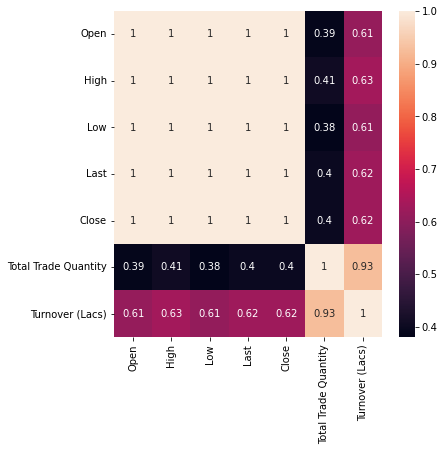

In [51]:
plt.figure(figsize=(6,6))
sns.heatmap(data.corr(), annot=True)

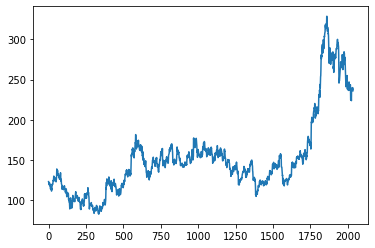

In [52]:
data_high=data.reset_index()['High']
plt.plot(data_high)

As LSTM are not robust to the scale of the data, so we apply MinMax Scaler to transform our values in the range of 0 and 1.

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
data_high = scaler.fit_transform(np.array(data_high).reshape(-1,1))

In [54]:
data_high.shape

(2035, 1)

In [55]:
data_high

array([[0.16344786],
       [0.15938199],
       [0.15917869],
       ...,
       [0.6391543 ],
       [0.62614353],
       [0.62268754]])

In [56]:
#Split the data into train and test split
training_size = int(len(data_high) * 0.75)
test_size = len(data_high) - training_size
train_data,test_data = data_high[0:training_size,:], data_high[training_size:len(data_high),:1]

In [57]:
training_size, test_size

(1526, 509)

In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]  
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [60]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [61]:
print(x_train.shape), print(y_train.shape)

(1425, 100, 1)
(1425,)


(None, None)

In [62]:
print(x_test.shape), print(y_test.shape)

(408, 100, 1)
(408,)


(None, None)

In [63]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM

In [64]:
### Create the Stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 15s 313ms/step - loss: 0.0111 - val_loss: 0.0327
Epoch 2/100
23/23 [==============================] - 6s 277ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 3/100
23/23 [==============================] - 6s 276ms/step - loss: 8.1645e-04 - val_loss: 0.0033
Epoch 4/100
23/23 [==============================] - 6s 278ms/step - loss: 7.6190e-04 - val_loss: 0.0033
Epoch 5/100
23/23 [==============================] - 6s 277ms/step - loss: 7.4010e-04 - val_loss: 0.0027
Epoch 6/100
23/23 [==============================] - 6s 277ms/step - loss: 7.2493e-04 - val_loss: 0.0028
Epoch 7/100
23/23 [==============================] - 6s 276ms/step - loss: 7.0142e-04 - val_loss: 0.0030
Epoch 8/100
23/23 [==============================] - 7s 286ms/step - loss: 7.1731e-04 - val_loss: 0.0046
Epoch 9/100
23/23 [==============================] - 6s 277ms/step - loss: 6.7387e-04 - val_loss: 0.0029
Epoch 10/100
23/23 [==============================] - 7s 298ms

Epoch 78/100
23/23 [==============================] - 6s 270ms/step - loss: 1.3122e-04 - val_loss: 8.8489e-04
Epoch 79/100
23/23 [==============================] - 6s 274ms/step - loss: 1.1851e-04 - val_loss: 6.3873e-04
Epoch 80/100
23/23 [==============================] - 7s 286ms/step - loss: 1.3144e-04 - val_loss: 0.0011
Epoch 81/100
23/23 [==============================] - 6s 276ms/step - loss: 1.1687e-04 - val_loss: 9.6716e-04
Epoch 82/100
23/23 [==============================] - 6s 261ms/step - loss: 1.1859e-04 - val_loss: 4.5319e-04
Epoch 83/100
23/23 [==============================] - 6s 257ms/step - loss: 1.3692e-04 - val_loss: 0.0011
Epoch 84/100
23/23 [==============================] - 6s 258ms/step - loss: 1.1532e-04 - val_loss: 0.0014
Epoch 85/100
23/23 [==============================] - 6s 257ms/step - loss: 1.1032e-04 - val_loss: 9.1283e-04
Epoch 86/100
23/23 [==============================] - 6s 262ms/step - loss: 1.2342e-04 - val_loss: 8.5498e-04
Epoch 87/100
23/23 [==

In [67]:
#predictions
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [68]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [69]:
#Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

135.89753229447012

In [70]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

226.178161930949

In [71]:
#Plotting
#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_high) - 1, :] = test_predict

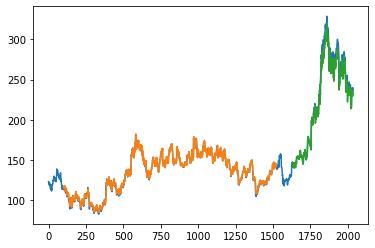

Green indicates the Predicted Data
Blue indicates the Complete Data
Orange indicates the Train Data


In [72]:
#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

print("Green indicates the Predicted Data")
print("Blue indicates the Complete Data")
print("Orange indicates the Train Data")

In [73]:
#Predict the next 28 days Stock Price
len(test_data), x_test.shape

(509, (408, 100, 1))

In [74]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [75]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
print(lst_output)

[0.5983884]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 0

9 day output [[0.42278525]]
10 day input [0.68428542 0.68936776 0.70217524 0.71803212 0.72941655 0.73144948
 0.74486684 0.76926205 0.75991055 0.74242732 0.73958122 0.74771295
 0.75991055 0.7584875  0.76621264 0.75462492 0.76316324 0.79670665
 0.80585485 0.7889815  0.78003659 0.73978451 0.73002643 0.73490547
 0.74872942 0.75991055 0.75462492 0.75401504 0.76174019 0.7737345
 0.82008538 0.80585485 0.81154706 0.77434438 0.78633869 0.79284407
 0.78328929 0.77109169 0.74385038 0.71193332 0.68733482 0.67818662
 0.65257166 0.64301687 0.65643423 0.67656028 0.67371417 0.65114861
 0.65521447 0.66761537 0.67838992 0.69993901 0.63122586 0.63508843
 0.64098394 0.64545639 0.64118723 0.63854442 0.63081927 0.62472047
 0.6330555  0.64728603 0.6574507  0.66761537 0.66720878 0.64159382
 0.62776987 0.63651149 0.63630819 0.62980281 0.62817646 0.63813783
 0.65358813 0.63183574 0.57653995 0.57816629 0.57613336 0.61943484
 0.57979264 0.57288067 0.62573694 0.63102257 0.6361049  0.62776987
 0.6269567  0.63590161

18 day output [[0.3727555]]
19 day input [0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 0.57979264 0.57288067 0.62573694
 0.63102257 0.6361049  0.62776987 0.6269567  0.63590161 0.62594023
 0.6391543  0.62614353 0.62268754 0.59838837 0.56540287 0.53370196
 0.50761563 0.48605517

27 day output [[0.3480013]]
[[0.5983883738517761], [0.5654028654098511], [0.5337019562721252], [0.5076156258583069], [0.4860551655292511], [0.46873340010643005], [0.4543839991092682], [0.44238734245300293], [0.4320368468761444], [0.4227852523326874], [0.4147814214229584], [0.40771815180778503], [0.4013911485671997], [0.3956473469734192], [0.3903733491897583], [0.38549017906188965], [0.38094595074653625], [0.37670791149139404], [0.3727554976940155], [0.36907532811164856], [0.36565694212913513], [0.3624893128871918], [0.35956141352653503], [0.35686013102531433], [0.3543700575828552], [0.35207509994506836], [0.3499579429626465], [0.34800130128860474]]


In [76]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [77]:
day_new.shape

(100,)

In [78]:
day_pred.shape

(28,)

In [80]:
len(data_high)

2035

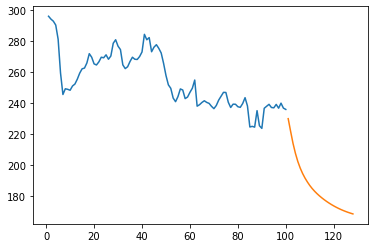

In [82]:
plt.plot(day_new, scaler.inverse_transform(data_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

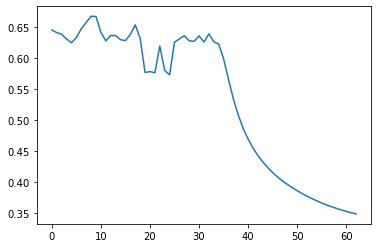

In [83]:
data_new = data_high.tolist()
data_new.extend(lst_output)
plt.plot(data_new[2000:])

In [84]:
data_new =scaler.inverse_transform(data_new).tolist()

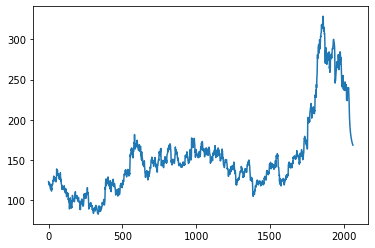

In [85]:
plt.plot(data_new)